# Part 1: Regression, Three Ways

### We will consider the problem of fitting a linear model. Given d-dimensional input data $x^{(1)}, ... , x^{(n)} \in R^d$ with real-valued labels $y^{(1)}, ... , y^{(n)} \in R$, the goal is to find the coefficient vector $a$ that minimizes the sum of the squared errors. The total squared error of $a$ can be written as $f(a) = \sum_{i=1}^{n}f_i(a)$, where $f_i(a) = (a^Tx^{(i)}-y^{(i)})^2$ denotes the squared error of the ith data point.

### The data in this problem will be drawn from the following linear model. For the training data, we select $n$ data points $x^{(1)}, ... , x^{(n)}$ , each drawn independently from a d-dimensional Gaussian distribution. We then pick the “true” coefficient vector $a^*$ (again from a d-dimensional Gaussian), and give each training point $x^{(i)}$ a label equal to $(a^*)^Tx^{(i)}$ plus some noise (which is drawn from a 1-dimensional Gaussian distribution).


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
test_mode = True

The following Python code will generate the data used in this problem.

In [2]:
#generate the data
d = 100
n = 1000
X = np.random.normal(0,1, size = (n,d))
a_true = np.random.normal(0,1,size=(d,1))
y = X @ a_true + np.random.normal(0, 0.5, size = (n,1))

### (a) (4 points) Least-squares regression has the closed form solution $a = (X^TX)^{−1}X^Ty$, which minimizes the squared error on the data. (Here $X$ is the $n * d$ data matrix as in the code above, with one row per data point, and $y$ is the n-vector of their labels.) Solve for $a$ and report the value of the objective function using this value $a$. For comparison, what is the total squared error if you just set a to be the all 0’s vector?


In [3]:
a_base = np.linalg.inv(X.T @ X) @ X.T @ y
print('closed form solution a:\n', a_base.T)

closed form solution a:
 [[-0.51509875  0.99250131 -1.46867565  1.13598337  0.79908287 -0.02364077
   0.01691246  0.94098754  0.74348091 -0.04285929  0.08618895  1.55551345
  -0.3432146   1.23853102 -0.5438406   0.74360754  0.36393111  0.2338206
   2.05374225 -0.11914071 -1.08281022  0.29593696  0.32386183 -0.77804589
   0.79086835 -0.72052533 -0.57141058 -1.18467397 -1.02547171 -0.60038548
  -0.19564817  0.62717471  2.39037135 -0.58385574  1.60793572  0.4388885
   0.67180093 -1.28457237 -1.11422957  0.31876763 -0.83204181  1.84428797
  -1.65896204 -0.91596145  0.39981459 -0.78432786  0.20337582  1.85883989
  -0.01559485 -1.3899322   0.98672222 -0.81279179 -0.55776741 -1.49052705
  -1.56200726  0.31975106  0.57838186  0.54832247 -0.53564545  2.61266987
  -0.16348811  0.57872959  0.44599973  0.98599784 -0.73969796  1.4463818
   0.16482718 -1.48536254 -2.19233861  0.21286897  0.43152451  1.00337875
  -0.63735087 -0.23667168  0.05676579  0.74513979  0.09069635 -1.38709251
   0.08005417  1

In [4]:
def MSELoss(y1, y2):
    return np.sum((y1-y2)**2)

In [5]:
y1 = X @ a_base
print('value of the objective function using value a = ', MSELoss(y1, y))
print('value of the objective function seting a to zero = ', MSELoss(y,0))

value of the objective function using value a =  214.10416812826935
value of the objective function seting a to zero =  110354.52859383206


<font color=blue> The squared error of the solving $a$ is far more less than all 0's vector. It means that the $a_{base}$ we get is correct. </font>

### (b) (6 points) In this part, you will solve the same problem via gradient descent on the squared-error objective function $f(a) = \sum_{i=1}^{n}{f_i(a)}$. Recall that the gradient of a sum of functions is the sum of their gradients. Given a point $a_t$, what is the gradient of f at $a_t$? 

b)

$$\because Xa = \left[\begin{matrix}
   \sum_\limits{i = 1}^dx_{1i}a_i \\
   \sum_\limits{i = 1}^dx_{2i}a_i \\
   \vdots \\
   \sum_\limits{i = 1}^dx_{ni}a_i \\
\end{matrix}\right]$$

$$\therefore \frac{\partial Xa}{\partial a_t} = \left[\begin{matrix}
    x_{1t} \\
    x_{2t} \\
    \vdots \\
    x_{nt} \\
\end{matrix}\right]$$

$$\therefore \frac{\partial f(a)}{\partial a_t} 
= \frac{\partial (Xa - y)^T(Xa - y)}{\partial a_t}
=  2(Xa - y)^T\left[\begin{matrix}
    x_{1t} \\
    x_{2t} \\
    \vdots \\
    x_{nt} \\
\end{matrix}\right]$$

### Now use gradient descent to find a coefficient vector $a$ that approximately minimizes the least squares objective function over the data. Run gradient descent three times, once with each of the step sizes $0.00005$, $0.0005$, and $0.0007$. You should initialize $a$ to be the all-zero vector for all three runs. Plot the objective function value for 20 iterations for all 3 step sizes on the same graph. Comment in 3-4 sentences on how the step size can affect the convergence of gradient descent (feel free to experiment with other step sizes). Also report the step size that had the best final objective function value and the corresponding objective function value.

In [6]:
#index from 0 to n-1
#gradient without l2
def getGradient(X, y, a, index, lambda_value = 0):
    #gradient below is for index -> a_t
    #gradient = 2 * (X@a  - y).T @ (X[:,index])
    #now change into index -> x_i
    gradient = (2 * (X[index]@a-y[index]) * X[index]).reshape(-1,1) + (2 * lambda_value * a).reshape(-1,1)
    return gradient.reshape((-1,1))

def GDTrain(X, y, step_size, train_step, metric = MSELoss, lambda_value = 0, evaluate=True):
    # extra dimension = 1 of a is necessary!!!
    # nasty broadcase algirhtm
    a = np.zeros((len(X[0]),1))
    obj_value = np.zeros(train_step+1)
    test_error = np.zeros(train_step//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for iters in range(train_step):
        gds = np.zeros((len(X[0]),1))
        for index in range(len(X)):
            gds += getGradient(X, y, a, index, lambda_value)
        #update a with gradient
        a = a - step_size * gds
        obj_value[iters+1] = metric(X @ a, y)
        if evaluate:
            if (iters+1) % 100 == 0:
                test_error[(iters+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

final objective values of step size = 0.000050 is: 2996.739988
final objective values of step size = 0.000500 is: 214.104206
final objective values of step size = 0.000700 is: 37456558.603408


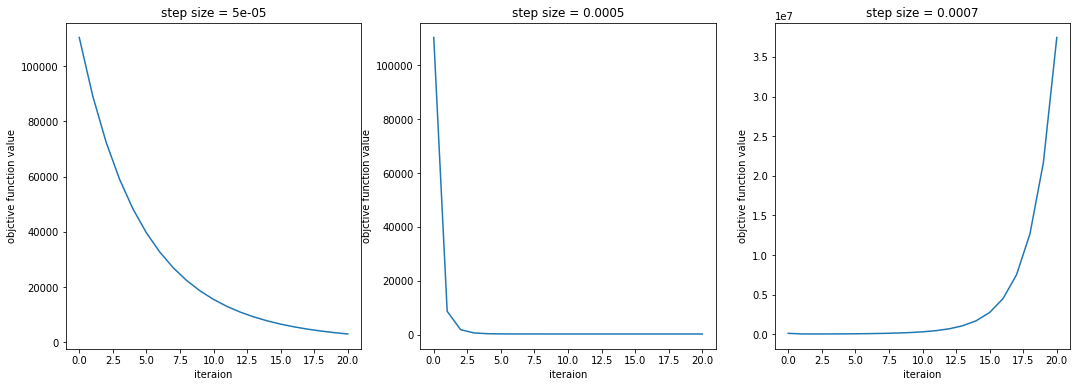

average running time = 0.3547966303047576 s


In [7]:
train_step = 20
step_size_list =  [0.00005,0.0005,0.0007]
plt.figure(figsize=(3*(len(step_size_list)+3),(len(step_size_list)+3)))

running_time = 0

for i in range(len(step_size_list)):
    running_start = time.clock()
    obj_value = GDTrain(X, y, step_size_list[i], train_step, evaluate=False)
    running_time += time.clock() - running_start
    x_index = list(range(0,train_step+1,1))
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('objctive function value')
    plt.plot(x_index, obj_value)
    print('final objective values of step size = %lf is: %lf' % (step_size_list[i], obj_value[-1]))

plt.show()
print('average running time =', running_time / len(step_size_list), 's')

<font color=blue>With the increase of step size, the convergence speed becomes faster, but when the step size is too large, the objective function will oscillate around the local optimum, or even diverge. 0.0005 is the best step size and the final objective values is similar to the closed solution's.</front>

### (c) (6 points) In this part you will run stochastic gradient descent to solve the same problem. Recall that in stochastic gradient descent, you pick one datapoint at a time, say $(x^{(i)}, y^{(i)})$, and update your current value of $a$ according to the gradient of $f_i(a) = (a^Tx^{(i)}-y^{(i)})^2$.

In [8]:
def SGDTrain(X, y, step_size, iters, metric = MSELoss,batch_size=1, evaluate = False, lambda_value = 0, random_radius = 0):
    a = np.random.uniform(0,random_radius, size = (len(X[0]),1))
    obj_value = np.zeros(iters+1)
    test_error = np.zeros(iters//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for i in range(iters):
        gd = np.zeros((len(X[0]),1))
        indexs = np.array(range(len(X)))
        np.random.shuffle(indexs)
        for index_i in range(batch_size):
            index = indexs[index_i]
            gd += getGradient(X, y, a, index, lambda_value)
        #update a with gradient
        a = a - step_size * gd
        obj_value[i+1] = metric(X @ a, y)
        if evaluate and (i+1) % 100 == 0:
            test_error[(i+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

### Run stochastic gradient descent using step sizes ${0.0005, 0.005, 0.01}$ and 1000 iterations. Plot the objective function value vs. the iteration number for all 3 step sizes on the same graph. Comment 3-4 sentences on how the step size can affect the convergence of stochastic gradient descent and how it compares to gradient descent. Compare the performance of the two methods. How do the best final objective function values compare? How many times does each algorithm use each data point? Also report the step size that had the best final objective function value and the corresponding objective function value.

final objective values of step size = 0.000500 is: 18364.418942
final objective values of step size = 0.005000 is: 504.889355
final objective values of step size = 0.010000 is: 227013.636890


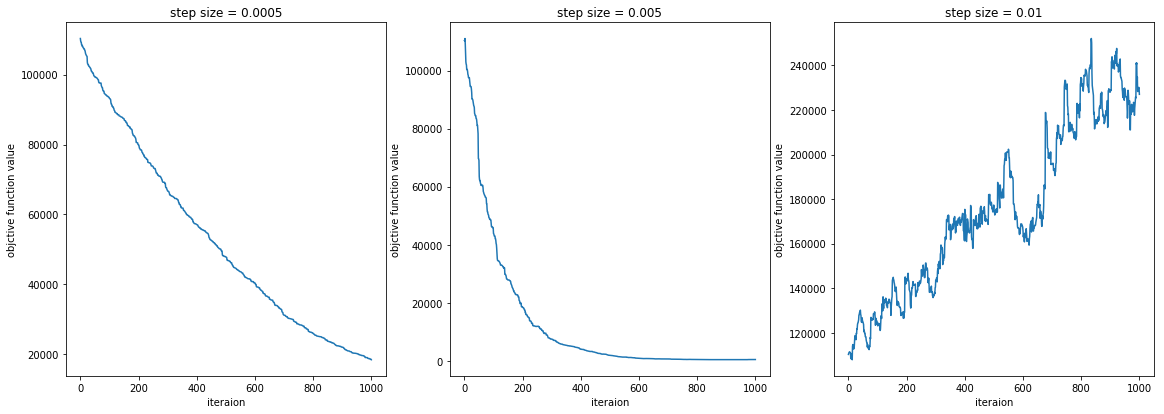

average running time = 0.40248140482380174 s


In [9]:
train_iter = 1000
step_size_list =  [0.0005,0.005,0.01]
plt.figure(figsize=(3*(len(step_size_list)+3.5),(len(step_size_list)+3.5)))

running_time = 0

for i in range(len(step_size_list)):
    running_start = time.clock()
    obj_value = SGDTrain(X, y, step_size_list[i], train_iter)
    running_time += time.clock() - running_start
    x_index = list(range(0,train_iter+1,1))
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('objctive function value')
    plt.plot(x_index, obj_value)
    print('final objective values of step size = %lf is: %lf' % (step_size_list[i], obj_value[-1]))

plt.show()
print('average running time =', running_time / len(step_size_list), 's')

<font color=blue>Similar to the (b), the larger step size, the faster convergence speed. Nevertheless,  when the step size becomes too large, the objective function will oscillate around the local optimum, or even diverge. 
The objective function values change roughly by using SGD. The overall tendency is similar to the GD one that uses a large step size.
The efficiency of SGD is much higher than GD. We can see that SGD converges time is only 1/5 times of GD's.
On the other hand, the best final objective function values of SGD is larger than that in GD i.e. 458.2807 vs 217.0854.

$$T_{GD}  = \frac{average time}{20 (iterations) * 1000 (data point/iteration)}  = 7.311e-06 s$$

$$T_{SGD} = \frac{average time}{1000 (iterations) * 1 (data point/iteration)}   = 0.3089e-06 s$$

Usng step size 0.005 in SGD we can get the optimal final objective function values.

In [10]:
#using another metric, y2 is the real ture output
def NormMSELoss(y1, y2):
    return np.sqrt(np.sum((y1 - y2)**2))/np.sqrt(np.sum(y2**2))

final objective values of step size = 0.000500 is: 0.398331
final objective values of step size = 0.005000 is: 0.065505
final objective values of step size = 0.010000 is: 1.131237


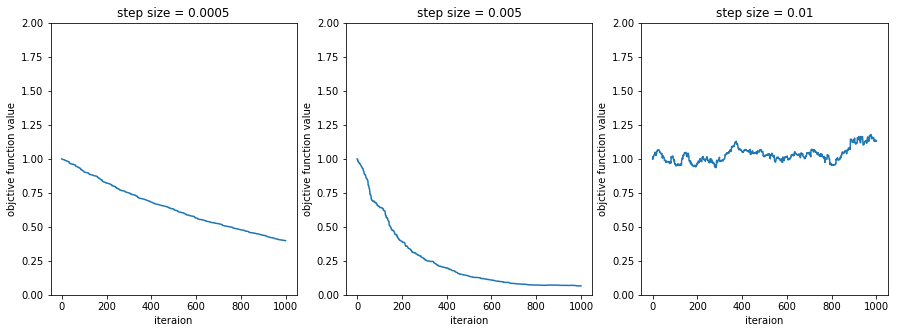

average running time = 0.4728396436541451 s


In [11]:
train_iter = 1000
step_size_list =  [0.0005,0.005,0.01]
plt.figure(figsize=(3*(len(step_size_list)+2),(len(step_size_list)+2)))

running_time = 0

for i in range(len(step_size_list)):
    running_start = time.clock()
    obj_value = SGDTrain(X, y, step_size_list[i], train_iter, NormMSELoss)
    running_time += time.clock() - running_start
    x_index = list(range(0,train_iter+1,1))
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('objctive function value')
    plt.ylim(0, 2)
    plt.plot(x_index, obj_value)
    print('final objective values of step size = %lf is: %lf' % (step_size_list[i], obj_value[-1]))
    
plt.show()
print('average running time =', running_time / len(step_size_list), 's')

# Part 2

### In the previous problem, the number of data points was much larger than the number of dimensions and hence we did not worry about generalization. (Feel free to check that the coefficient vector $a$ that you computed accurately labels new datapoints drawn from the same distribution.) We will now consider the setting where $d = n$, and examine the test error along with the training error. Use the following Python code for generating the training data and test data.


In [12]:
#initialize variable to get the avg error
train_n = 100
test_n = 1000
d = 100
X_train = np.random.normal(0,1, size=(train_n,d))
a_true = np.random.normal(0,1, size=(d,1))
y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
X_test = np.random.normal(0,1, size=(test_n,d))
y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))

def init():
    global X_train, a_true, y_train, X_test, y_test
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))

### (a) (2 points) We will first setup a baseline, by finding the test error of the linear regression solution $a=X^{-1}y$ without any regularization. This is the closed-form solution for the minimizer of the objective function $f(a)$. (Note the formula is simpler than in 1(a) because now $X$ is square.) Report the training error and test error of this approach, averaged over 10 trials. For better interpretability, report the normalized test error $\hat{f}(a)$ rather than the value of the objective function $f(a)$, where by definition $$ \hat{f}(a) = \frac{||Xa-y||_2}{||y||_2}　$$


In [13]:
trial_times = 100
training_error_base1 = 0
test_error_base1 = 0

for _ in range(trial_times):
    init()
    a_base = np.linalg.inv(X_train) @ y_train
    training_error_base1 += NormMSELoss(X_train @ a_base, y_train)
    test_error_base1 += NormMSELoss(X_test @ a_base, y_test)

training_error_base1 /= trial_times
test_error_base1 /= trial_times
print('training error = ', training_error_base1)
print('test error = ', test_error_base1)

training error =  3.957985496934647e-14
test error =  1.745062485643682


<font color=blue>We can see that the test error is much larger than training error,  this means we encounter overfitting problem when the train sample size is much more indigent than test sample size.</font>

### (b) (5 points) We will now examine $l_2$ regularization as a means to prevent overfitting. The $l_2$ regularized objective function is given by the following expression:
$$\sum_{i=1}^m{(a^Tx^{(i)}-y^{(i)})^2+\lambda ||a||^2_2}$$

### This has a closed-form solution $a=(X^TX+\lambda I)^{-1}X^Ty$. Using this closed-form solution, present a plot of the normalized training error and normalized test error $\hat{f}(a)$ for $\lambda = {0.0005, 0.005, 0.05, 0.5, 5, 50, 500}$. As before, you should average over 10 trials. Discuss the characteristics of your plot, and also compare it to your answer to (a).

In [14]:
trial_times = 100
lambda_list = [0.00005, 0.0005,0.005,0.05,0.5,5,50,500]
training_error_base2 = []
test_error_base2 = []
print('|lambda|training error|test error|')
for i in range(len(lambda_list)):
    training_error = 0
    test_error = 0
    a_base = 0
    for _ in range(trial_times):
        init()
        a_base = np.linalg.inv(X_train.T @ X_train + lambda_list[i] * np.eye(len(X_train)))@X_train.T@y_train
        training_error += NormMSELoss(X_train @ a_base, y_train)
        test_error += NormMSELoss(X_test @ a_base, y_test)
    
    training_error_base2.append(training_error/trial_times)
    test_error_base2.append(test_error/trial_times)
    
    print('|%6.4g|      %6lf|  %8.5lf|' %(lambda_list[i], training_error_base2[i],test_error_base2[i]))
    
#construct error dictionary
training_error_base_dic = dict(zip(lambda_list,training_error_base2))
test_error_base_dic = dict(zip(lambda_list,test_error_base2))

|lambda|training error|test error|
| 5e-05|      0.000382|   1.23873|
|0.0005|      0.001173|   0.74296|
| 0.005|      0.003363|   0.44788|
|  0.05|      0.006278|   0.26746|
|   0.5|      0.016274|   0.23548|
|     5|      0.068466|   0.34115|
|    50|      0.292422|   0.57418|
|   500|      0.741764|   0.86520|


<font color="blue"> We can consider the $\lambda$ of (a) is 0 as a special situation of generalization. The result elucidates that as the $\lambda$ increasing, training error would  also increasing. The test error would decrease in early period and then increase again. The best $\lambda$ of minimum test error is 0.5.  </font>

### (c) (5 points) Run stochastic gradient descent (SGD) on the original objective function $f(a)$, with the initial guess of $a$ set to be the all 0’s vector. Run SGD for 1,000,000 iterations for each different choice of the step size, ${0.00005, 0.0005, 0.005}$. 

### Report the normalized training error and the normalized test error for each of these three settings, averaged over 10 repetitions/trials. 

### How does the SGD solution compare with the solutions obtained using $l_2$ regularization? 
### Note that SGD is minimizing the original objective function, which does not have any regularization. 

### In Part (a) of this problem, we found the optimal solution to the original objective function with respect to the training data. How does the training and test error of the SGD solutions compare with those of the solution in (a)? 

### Can you explain your observations? (It may be helpful to also compute the normalized training and test error corresponding to the true coefficient vector $f(a^∗)$, for comparison.)


<span id="jump"></span>

|step size|training error|test error|
|    5e-05|      0.324751|  0.605891|
|   0.0005|      0.051776|  0.344899|
|    0.005|      0.021413|  0.239699|


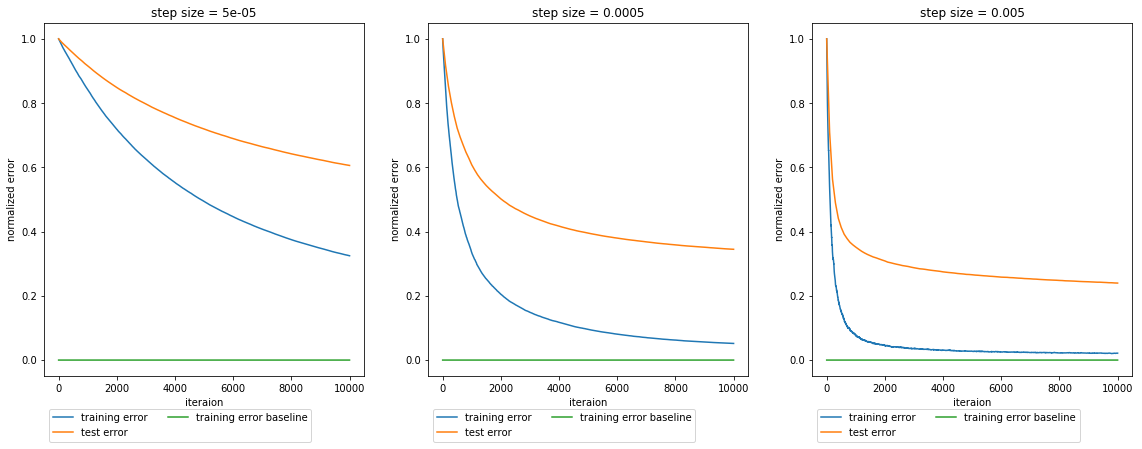

average running time = 1.3061733894313947 s


In [15]:
train_iter = 1000000
trial_times = 10
if test_mode == True:
    train_iter = 10000
step_size_list =  [0.00005,0.0005, 0.005]
plt.figure(figsize=(3*(len(step_size_list)+3.5),(len(step_size_list)+3.5)))
print('|step size|training error|test error|')

total_running_time = 0
for i in range(len(step_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, step_size_list[i], train_iter,\
                                             NormMSELoss, evaluate = True)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors

    total_running_time += running_time / trial_times
    
    print('|%9.4g|      %6lf|  %6lf|' %(step_size_list[i], \
                                        total_training_errors[-1]/trial_times, \
                                        total_test_errors[-1]/trial_times))
    
    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    
    #draw base line
    global training_error_base, test_error_base

    plt.plot(x_index1, training_error_base1 * np.ones(len(x_index1)))
    
    plt.legend(['training error', 'test error', 'training error baseline'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(step_size_list), 's')

<font color="blue"> We test 10 times and find the best test error is aroound 0.2 on average. We need huge amount of iterations to update the parameters of $a$, and rebound around 0.2.

Compare with part(a), we get higher but still near to zero train error and much lower test error i.e. 0.2 vs 2.8925. However, there is still a wide gap between training error and test error, meaning that overfitting problem occurs again.

Using SGD algorithm, we would not exploit all training data at once, but use them one by one. When the iterations get larger, we training on the identical data without any other constraints which could not alleviate the overfitting problem. 

### (d) (7 points) We will now examine the behavior of SGD in more detail. For step sizes {0.00005, 0.005} and 1,000,000 iterations of SGD,

### (i) Plot the normalized training error vs. the iteration number. On the plot of training error, draw a line parallel to the x-axis indicating the error $\hat{f}(a^*)$ of the true model $a^*$
### (ii) Plot the normalized test error vs. the iteration number. Your code might take a long time to run if you compute the test error after every SGD step—feel free to compute the test error every 100 iterations of SGD to make the plots.


<font color="blue"> These two plots are in the [part(c)](#jump).

### (iii) Plot the $l_2$ norm of the SGD solution vs. the iteration number.

### Comment on the plots. What can you say about the generalization ability of SGD with different step sizes? Does the plot correspond to the intuition that a learning algorithm starts to overfit when the training error becomes too small, i.e. smaller than the noise level of the true model? How does the generalization ability of the final solution depend on the $l_2$ norm of the final solution?


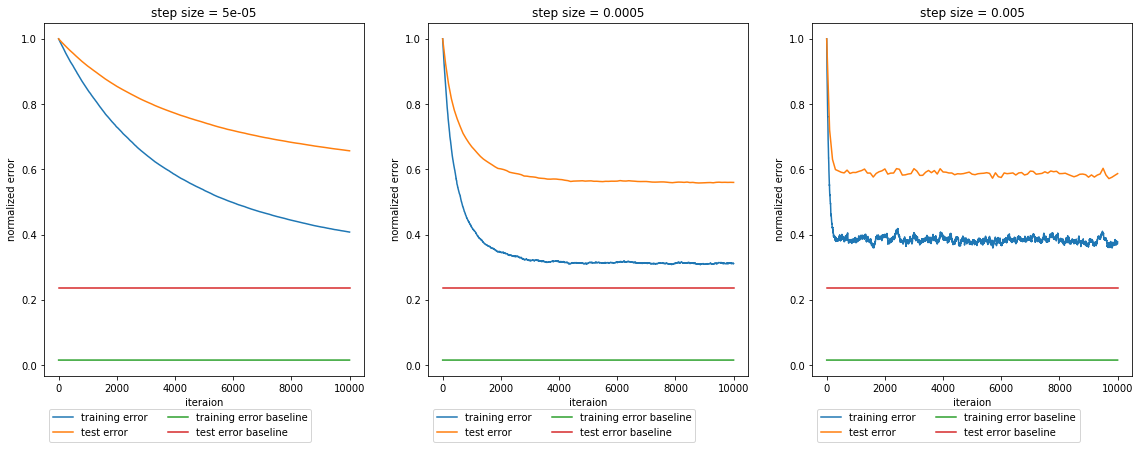

average running time = 1.316766286094709 s


In [16]:
train_iter = 1000000
trial_times = 10
if test_mode == True:
    train_iter = 10000
step_size_list =  [0.00005,0.0005, 0.005]
plt.figure(figsize=(3*(len(step_size_list)+3.5),(len(step_size_list)+3.5)))

total_running_time = 0

for i in range(len(step_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, step_size_list[i], train_iter,\
                                             NormMSELoss, evaluate = True, lambda_value = 0.5)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors
    
    total_running_time += running_time / trial_times

    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    
    #draw base line
    global training_error_base, test_error_base
    plt.plot(x_index1, training_error_base_dic[0.5] * np.ones(len(x_index1)))
    plt.plot(x_index2, test_error_base_dic[0.5] * np.ones(len(x_index2)))
    
    plt.legend(['training error', 'test error', 'training error baseline', 'test error baseline'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(step_size_list), 's')

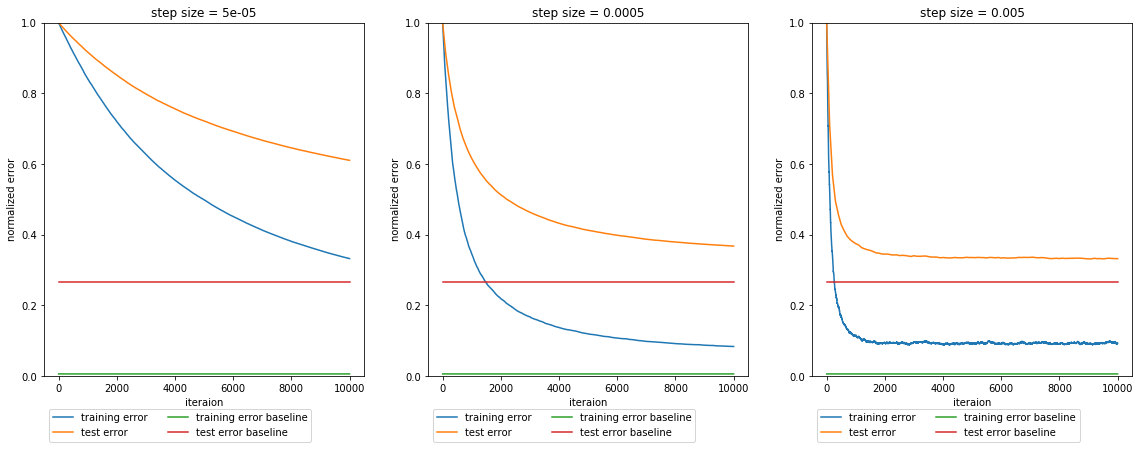

average running time = 1.2469737496513769 s


In [17]:
train_iter = 1000000
trial_times = 10
if test_mode == True:
    train_iter = 10000
step_size_list =  [0.00005,0.0005, 0.005]
plt.figure(figsize=(3*(len(step_size_list)+3.5),(len(step_size_list)+3.5)))

total_running_time = 0
for i in range(len(step_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, step_size_list[i], train_iter,\
                                             NormMSELoss, evaluate = True, lambda_value = 0.05)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors
    
    total_running_time += running_time / trial_times

    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(1,len(step_size_list),i+1)
    plt.title('step size = ' + str(step_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.ylim(0,1)
    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    
    #draw base line
    global training_error_base, test_error_base
    plt.plot(x_index1, training_error_base_dic[0.05] * np.ones(len(x_index1)))
    plt.plot(x_index2, test_error_base_dic[0.05] * np.ones(len(x_index2)))
    
    plt.legend(['training error', 'test error', 'training error baseline', 'test error baseline'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(step_size_list), 's')

<font color="blue">
    As to different step size, when the step size increasing, the oscillation amplitude of the object function becomes larger, but convergence faster. The model show more and more preference to sum of square error when step size becomes larger. 

The plot corresond to the intuition that a learning algorithm starts to overfit when the training error becomes too small. Intuitively, the training error should not be less than the noise level of true model. If the training error is less than the noise level, it reveals that the model is not in accord with the true distribution of the data sample with noise. In other perspective, it is overfitting with the training sample. 

In this situation, generalized item $l_2$ act as a role to control the total error. The larger the value of $\lambda$, the severer conflict between sum of square item error and generalized item error. The conflict scale could be visualized as oscillation amplitute of the object function.We test $\lambda=0.5$ and $\lambda=0.05$ . We found $\lambda=0.05$ get lower error on both training and testing set, which shows it has the better generalization ability


### (e) (4 points) We will now examine the effect of the starting point on the SGD solution. Fixing the step size at 0.00005 and the maximum number of iterations at 1,000,000, choose the initial point randomly from the d-dimensional sphere with radius $r = {0, 0.1, 0.5, 1, 10, 20, 30}$, and plot the average normalized training error and the average normalized test error over 10 iterations vs $r$. Comment on the results, in relation to the results from part (b) where you explored different $l_2$ regularization coefficients. Can you provide an explanation for the behavior seen in this plot?

begin


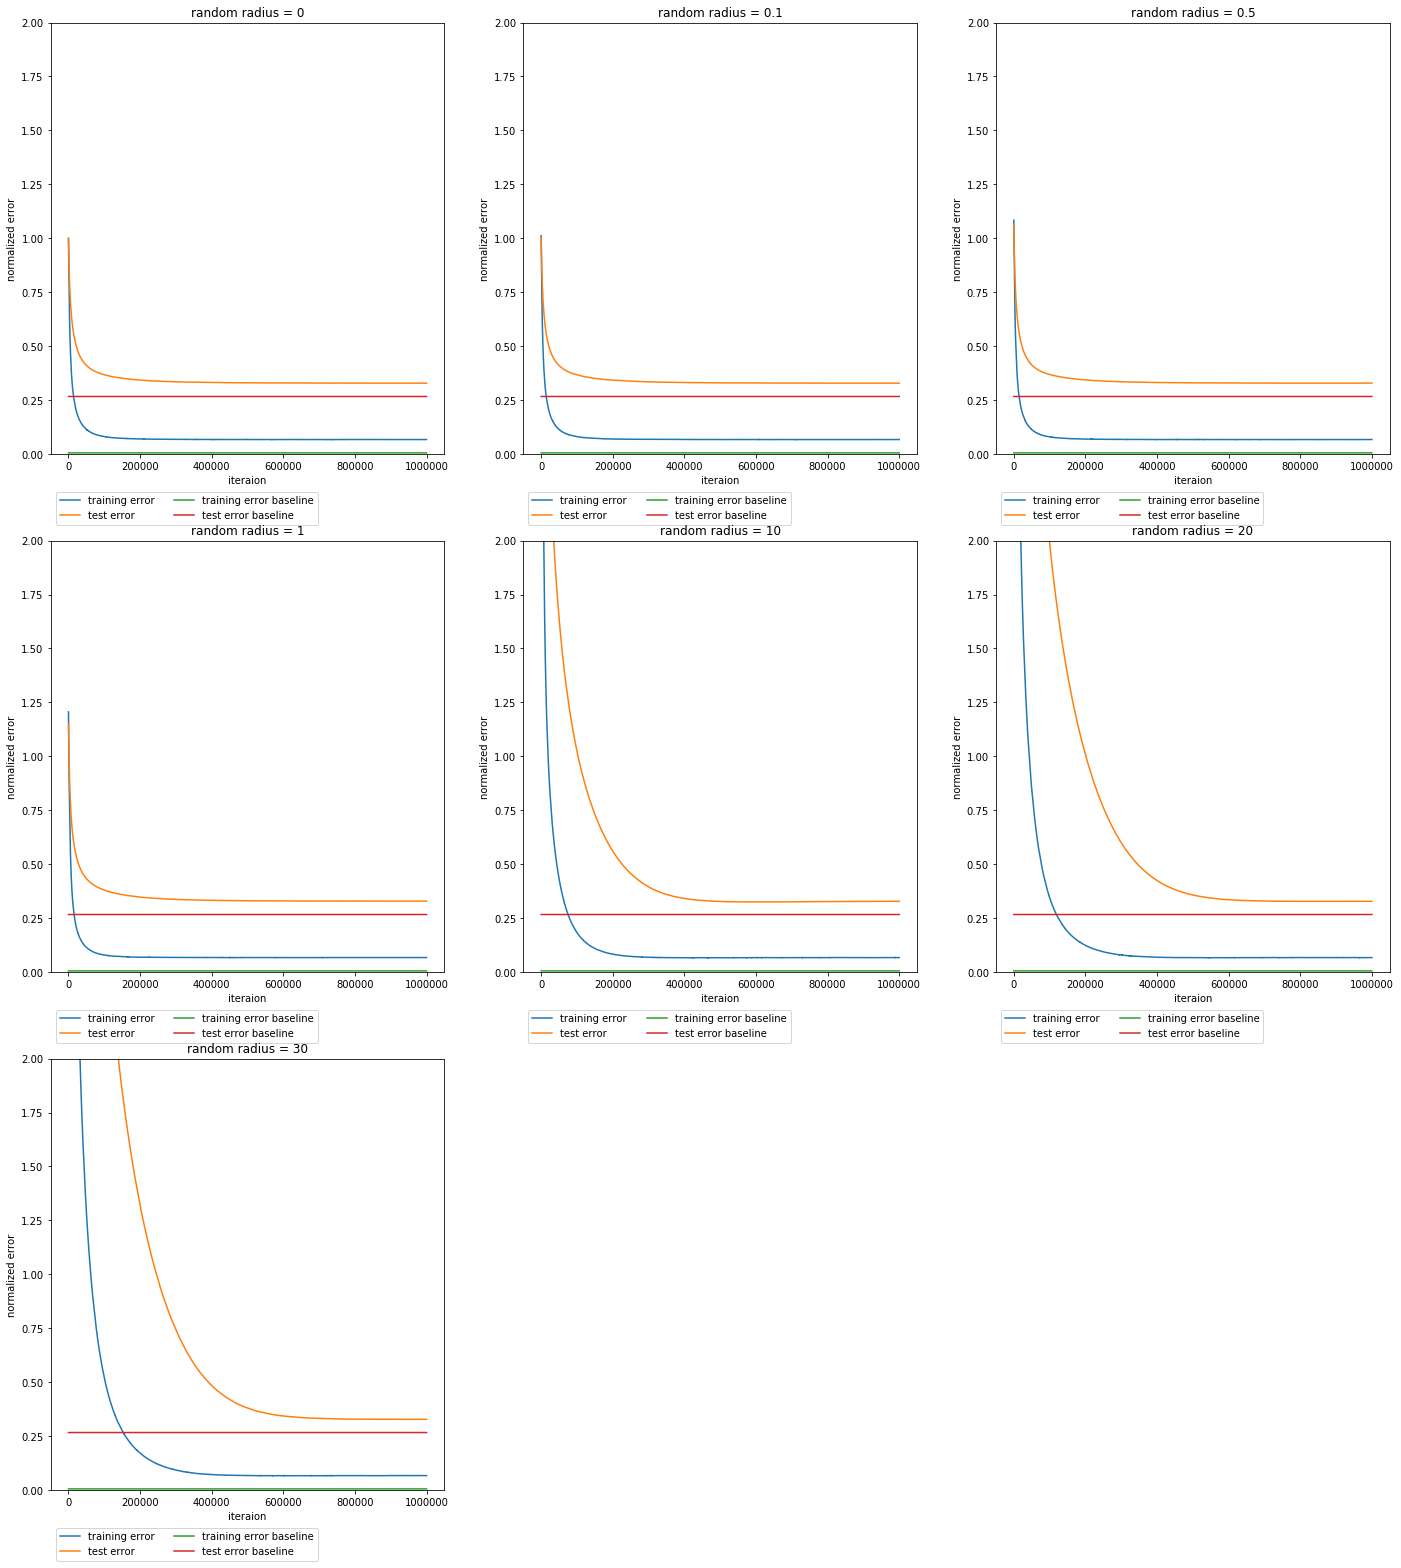

average running time = 109.0242187331905 s


In [18]:
train_iter = 1000000
trial_times = 10
test_mode = False
if test_mode == True:
    train_iter = 10000
radius_list =  [0,0.1,0.5,1,10,20,30]
plt.figure(figsize=(3*(len(step_size_list)+5),3*(len(step_size_list)+6)))
total_running_time = 0
print("begin")
for i in range(len(radius_list)):
   #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, 0.00005, train_iter,\
                                             NormMSELoss, evaluate = True, lambda_value = 0.05,\
                                               random_radius = radius_list[i])
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors
    
    total_running_time += running_time / trial_times

    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(3,len(radius_list) // 3 + 1,i+1)
    plt.title('random radius = ' + str(radius_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.ylim(0, 2)

    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    
    #draw base line
    global training_error_base, test_error_base
    plt.plot(x_index1, training_error_base_dic[0.05] * np.ones(len(x_index1)))
    plt.plot(x_index2, test_error_base_dic[0.05] * np.ones(len(x_index2)))
    
    plt.legend(['training error', 'test error', 'training error baseline', 'test error baseline'],\
              bbox_to_anchor = (0,-0.175), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(radius_list), 's')

<font color="blue">We can see that the final solution of different initial point is similar, but the convergence speed is different. Because $a$ obeys Gauss distribution with a mean value of 0, $a$ is near 0 vector. When we initial the point close to 0, it would converge faster than we use initial point with a  larger radius sphere.</font>



# Part3
### We will now examine the setting where $d > n$. Choose $d = 200$ and $n = 100$. Use the following Python code for generating the training data and test data.

In [18]:
#generate data
train_n = 100
test_n = 10000
d = 200
X_train = np.random.normal(0,1, size=(train_n,d))
a_true = np.random.normal(0,1, size=(d,1))
y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
X_test = np.random.normal(0,1, size=(test_n,d))
y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
def GetSMatrix(X):
    S = np.zeros((len(X[0]),len(X[0])))
    mean = np.mean(X, axis = 0).reshape(-1,1)
    for x in X:
        xx = x.reshape(-1,1)
        S += (xx - mean) @ (xx - mean).T
    return S

def GetMainVector(X, dimension):
    S = GetSMatrix(X)
    eigvalue, eigvector = np.linalg.eigh(S)
    #kmax_eigvalue = eigvalue.argsort()[-dimension:]
    kmax_eigvalue_index = np.argpartition(eigvalue, -dimension)[-dimension:]
    W = eigvector[:,kmax_eigvalue_index]
    return W

### (a) (11 points: 4 for performance, 7 for analysis and discussion) The goal of this problem is to achieve the best test error that you can, using the techniques from the previous two parts and/or by other means. (Of course, your learning algorithm can only use the training data for this purpose, and cannot refer to a_true.) You will receive credit based on your accuracy. Report the average test error you obtain, averaged over 1000 trials (where you re-pick a_true and the data in each trial). Feel free to use regularization, SGD, gradient descent, or any other algorithm you want to try, but clearly describe the algorithm you use in human-readable pseudo-code. Briefly discuss the approach you used, your thought process that informed your decisions, and the extent to which you believe a better test error is achievable. Your score will be based on a combination of the short discussion and the average test error you obtain. A paragraph of analysis is enough to earn full credit—don’t go overboard unless you really want to.

<font color = "blue">From the experiment of part 1 and part 2, we find tat step size of 0.0005 is the fastest stable step size for SGD training, so we choose step size=0.0005. We can see from part 1 that GD have the lower error than SGD, and the training data size is small, so we can combine thiese two algorithm together to train the data by using larger batch size. We use regularization to alleviate overfitting and set the initial point in random raidus of 0.

In [19]:
def getGradient(X, y, a, index, lambda_value = 0):
    #gradient below is for index -> a_t
    #gradient = 2 * (X@a  - y).T @ (X[:,index])
    #now change into index -> x_i
    gradient = (2 * (X[index]@a-y[index]) * X[index]).reshape(-1,1) + (2 * lambda_value * a).reshape(-1,1)
    return gradient.reshape((-1,1))
#using another metric, y2 is the real ture output
def NormMSELoss(y1, y2):
    return np.sqrt(np.sum((y1 - y2)**2))/np.sqrt(np.sum(y2**2))
def SGDTrain(X, y, step_size, iters, metric, batch_size=1, evaluate = False, lambda_value = 0, random_radius = 0):
    a = np.random.uniform(0,random_radius, size = (len(X[0]),1))
    obj_value = np.zeros(iters+1)
    test_error = np.zeros(iters//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for i in range(iters):
        gd = np.zeros((len(X[0]),1))
        indexs = np.array(range(len(X)))
        np.random.shuffle(indexs)
        for index_i in range(batch_size):
            index = indexs[index_i]
            gd += getGradient(X, y, a, index, lambda_value).astype(np.float64)
        #update a with gradient
        a = a - step_size * gd
        obj_value[i+1] = metric(X @ a, y)
        if evaluate and (i+1) % 100 == 0:
            test_error[(i+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

In [20]:
trial_times = 100
training_error_base1 = 0
test_error_base1 = 0

for _ in range(trial_times):
    training_error_base1 += NormMSELoss(X_train @ a_true, y_train)
    test_error_base1 += NormMSELoss(X_test @ a_true, y_test)

training_error_base1 /= trial_times
test_error_base1 /= trial_times
print('training error = ', training_error_base1)
print('test error = ', test_error_base1)

training error =  0.0377750282520265
test error =  0.033915765575832736


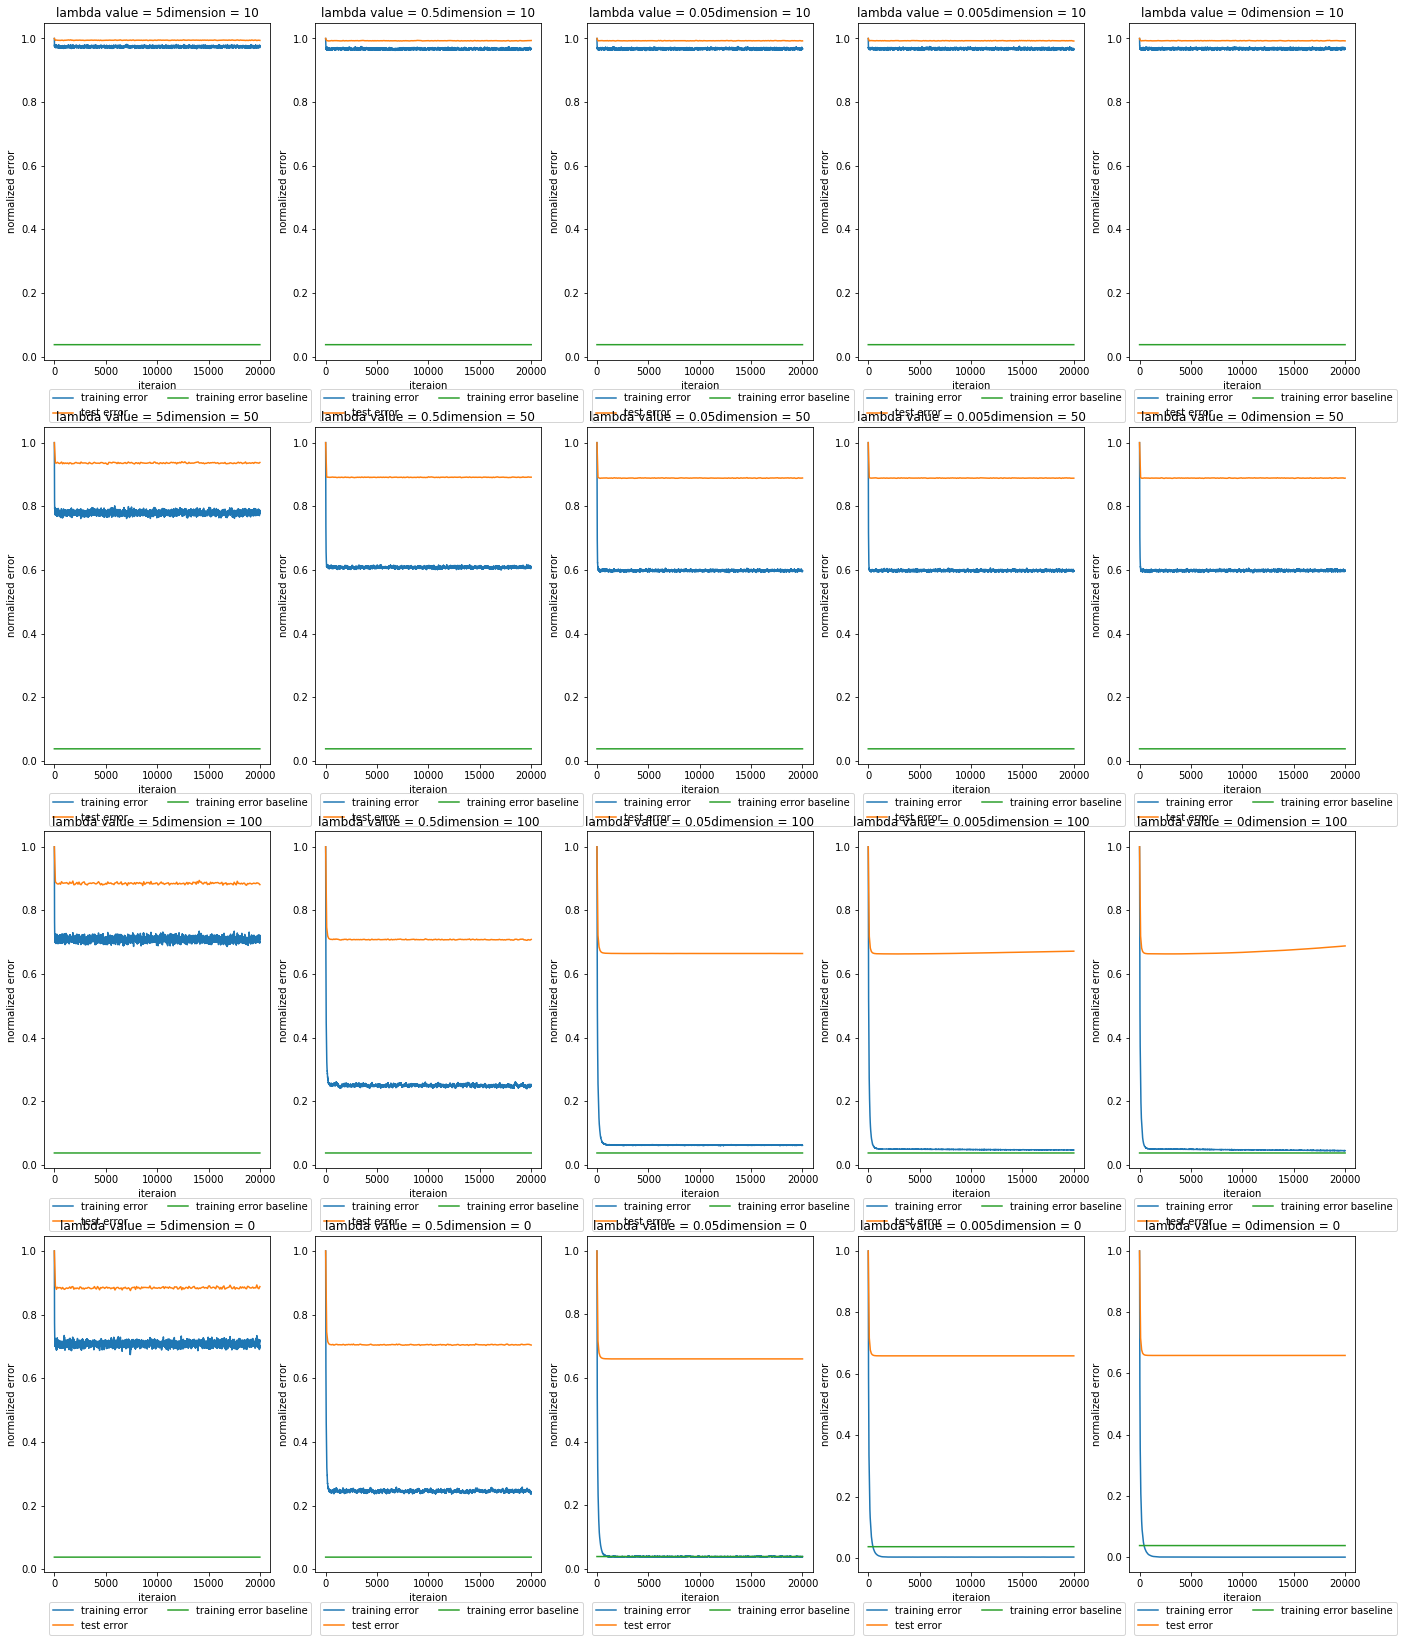

average running time = 6.408483675733324 s


In [25]:
train_iter = 20000
trial_times = 10
total_running_time = 0

dimension_list = [10, 50, 100, 0]
lambda_value_list = [5, 0.5, 0.05, 0.005, 0]
plt.figure(figsize=(5*len(dimension_list)+3.5,(5*len(lambda_value_list)+3.5)))

train_error = {10: np.zeros(5), 50: np.zeros(5), 100: np.zeros(5), 0: np.zeros(5)}

x_train_tmp = X_train[:]
x_test_tmp = X_test[:]
for j in range(len(dimension_list)):
    dimension = dimension_list[j]
    if dimension != 0:
        M = GetMainVector(X_train, dimension)
        X_train = X_train @ M
        X_test = X_test @ M
    for i in range(len(lambda_value_list)):
        #for 10 times
        running_time = 0
        total_training_errors = np.zeros(train_iter+1)
        total_test_errors = np.zeros(train_iter//100+1)

        for _ in range(trial_times):
            running_start = time.clock()
            training_errors, test_errors = SGDTrain(X_train, y_train, 0.0005, train_iter,\
                                                     NormMSELoss, batch_size=10, evaluate = True, lambda_value = lambda_value_list[i])
            running_time += time.clock() - running_start
            total_training_errors += training_errors
            total_test_errors += test_errors

        total_running_time += running_time / trial_times

        x_index1 = list(range(0,train_iter+1,1))
        x_index2 = list(range(0,train_iter+1,100))

        plt.subplot(4, 5,j*5+i+1)
        plt.title('lambda value = ' + str(lambda_value_list[i]) + 'dimension = ' + str(dimension_list[j]))
        plt.xlabel('iteraion')
        plt.ylabel('normalized error')
        plt.plot(x_index1, total_training_errors/trial_times)
        plt.plot(x_index2, total_test_errors/trial_times)
        # print("lambda value: %lf; dimension: %d; final testing error: %lf; final training error: %lf  " % (lambda_value_list[i], dimension_list[j], total_test_errors[-1]/trial_times, total_training_errors[-1]/trial_times))
        
        train_error[dimension][i] = total_test_errors[-1]/trial_times
        
        #draw base line
        global training_error_base, test_error_base

        plt.plot(x_index1, training_error_base1 * np.ones(len(x_index1)))

        plt.legend(['training error', 'test error', 'training error baseline'],\
                  bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

    X_train = x_train_tmp
    X_test = x_test_tmp
plt.show()
df = pd.DataFrame({'lambda':lambda_value_list, 'dimension 10':train_error[10], 'dimension 50':train_error[50], 'dimension 100':train_error[100], 'Without dimension reduction':train_error[0], 'base error':np.ones(5)*training_error_base1})
print('average running time =', total_running_time / len(dimension_list) / len(lambda_value_list), 's')

In [26]:
df

,lambda,dimension 10,dimension 50,dimension 100,Without dimension reduction,base error
0,5.000,0.993997,0.937611,0.881113,0.887913,0.037775
1,0.500,0.993640,0.891467,0.708864,0.704320,0.037775
2,0.050,0.992536,0.888889,0.664614,0.660072,0.037775
3,0.005,0.992089,0.888290,0.671951,0.658717,0.037775
4,0.000,0.992546,0.888391,0.688467,0.658707,0.037775


<font color="blue"> 
We attempt to improve generalization ability by using PCA to reduce dimension of X. From the experiment before, we fix batch size as 10 and learning rate at 0.0005. Testing the parameters $\lambda \in {0, 0.005, 0.05, 0.5, 5}$ and $dimension after reduce \in {10, 50, 100, 0}$, 0 means not to reduce the dimension. 
<br>    
From the output of testing above, we can see that when we reduce the dimension to 100, the testing error is similar to the one without dimension reduction. When the training error less than baseline, there is overfitting absoulutely. For these reasons, we choose reduced dimension as 100 and lambda value as 0.05, which has the lowest but higher traning error than the baseline error.
</font>